# Spampinato mice retina mea252ch pair recording - 1

## Part 1) Cleaning the ground-truth data

This set of notebooks the dataset is from paired juxtacellular/extracellular recordings from mice retina _in vitro_.
The MEA has 252 channels.

The official publication of this open dataset can be found at the following address:
https://zenodo.org/record/1205233#.W9mq1HWLTIF

These datasets were used by Pierre Yger et al in the following "spyking circus" paper:
https://elifesciences.org/articles/34518


After inspecting the juxta-cellular data, we found that some recordings don't have a good enough quality to be considered as "ground truth". To be "ground truth", a unit is required to be stable in the detection, peak signal-to-noise ratio (SNR) and amplitude.

At the end of our quality assessment, some files are removed for the main study shown in [**"spampinato-mice-retina-mea252ch-pair-recording-part2"**](https://spikeinterface.github.io/blog/spampinato-mice-retina-mea252ch-pair-recording-part2/).


### Quality assessment details

First, we have to run the script `detect_ground_truth_spike_on_juxta.py`.

This script:
  * unzips the downloaded data
  * runs a juxta cellular detection
  * generates figure to manually check juxtacellular quality
  * computes the peak SNR on the max channel of the MEA.

Before running the script, we need:
  * to create a folder **basedir**
  * to create a subfolder **basedir/original_files** that contain all zip downloded (20160415_patch2.tar.gz, ...)

Then we can run the script `detect_ground_truth_spike_on_juxta.py`

After we can:
  * inscpect in each folder explanatory figures.


Author: [Samuel Garcia](https://github.com/samuelgarcia), CRNL, Lyon

# Criterium to keep or remove a file

Having a very reliable ground truth is crucial, as all the following spike sorting performance metrics are designed on the hypothesis the ground truth is **indeed ground truth**.

In the following script we choose a high threshold value for peak detection: **thresh = med + 8\*mad**, where:
  * **med** is the median of the signal (the baseline),
  * **mad** is the median absolut deviation (a robust std estimation),
  * 8 is a quite high relative threshold that ensures the absence of false positive.
  
  
Two main criteria were used to keep a recording:
  * the distribution of the peak values of the juxtacelullar action potentials must have a Gaussian distribution:
     * a truncated Gaussian suggests that false negative (misses) corrupt the "ground truth",
     * a multi-modal distribution suggests either that an amplitude drift occured or that two (or more) cells were present.



# List of accepted recording (8)


```python
'20160415_patch2',
'20170803_patch1',
'20160426_patch3', 
'20170725_patch1',
'20170621_patch1',
'20160426_patch2', 
'20170728_patch2',
'20170713_patch1',

```


# List of rejected recording (11)

```python
'20170706_patch2'
'20170629_patch2'
'20170622_patch2'
'20170726_patch1'
'20170706_patch1'
'20170706_patch3'
'20170627_patch1'
'20170630_patch1'
'20170629_patch3'
'20170623_patch1'
'20170622_patch1'

```

(Some reader may think that we are too strict, but we prefer to be strict to ensure safe final results.
Feel free to modify this list as you prefer using your own criteria.)

In [2]:
import matplotlib

import os, shutil
import zipfile, tarfile
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# path
basedir = '/media/samuel/dataspikesorting/DataSpikeSortingHD2/Pierre/zenodo/'
recording_folder = basedir + 'original_files/'
ground_truth_folder = basedir + 'ground_truth/'

%matplotlib notebook

# Step 1 : Re-detect properly juxtacellular peaks

In [ ]:
# this tridesclous utils are imported only for juxta detection to keep this script simple
from tridesclous.peakdetector import  detect_peaks_in_chunk
from tridesclous.tools import median_mad
from tridesclous.waveformtools import extract_chunks

In [ ]:
rec_names = ['20170629_patch3', '20170728_patch2', '20170630_patch1', '20160426_patch2', '20170621_patch1',
             '20170627_patch1', '20170706_patch3', '20170706_patch1', '20170726_patch1', '20170725_patch1',
             '20160426_patch3', '20170622_patch1', '20170623_patch1', '20170622_patch2', '20170629_patch2',
             '20170713_patch1', '20160415_patch2', '20170706_patch2', '20170803_patch1']

## Unzip all

In [ ]:
# this unzip all files into recording_folder
for rec_name in rec_names:
    filename = recording_folder + rec_name + '.tar.gz'

    if os.path.exists(recording_folder+rec_name) and os.path.isdir(recording_folder+rec_name):
        continue
    print('unzip', rec_name)
    t = tarfile.open(filename, mode='r|gz')
    t.extractall(recording_folder+rec_name)

## Detect ground-truth spikes on juxta

In [ ]:
if not os.path.exists(ground_truth_folder):
    os.mkdir(ground_truth_folder)

gt_info = pd.DataFrame(index=rec_names)

for rec_name in rec_names:
    print('detect_juxta: ', rec_name)

    # get juxta signal
    dirname = recording_folder + rec_name + '/'
    for f in os.listdir(dirname):
        if  f.endswith('juxta.raw'):
            juxta_filename = dirname + f
    juxta_sig = np.memmap(juxta_filename, dtype='float32')

    # get mea signals
    for f in os.listdir(dirname):
        if f.endswith('.raw') and not f.endswith('juxta.raw'):
            mea_filename = dirname + f
    with open(mea_filename.replace('.raw', '.txt'), mode='r') as f:
        offset = int(re.findall('padding = (\d+)', f.read())[0])
    mea_sigs = np.memmap(mea_filename, dtype='uint16', offset=offset).reshape(-1, 256)
    print(1)
    # select only the 252 mea channel (see PRB file)
    mea_sigs = mea_sigs[:, list(range(126)) + list(range(128,254))]
    print(2)
    gt_folder = ground_truth_folder + rec_name + '/'
    os.mkdir(gt_folder)

    # detect spikes
    med, mad = median_mad(juxta_sig)
    print(3)
    thresh = med + 8*mad
    gt_indexes = detect_peaks_in_chunk(juxta_sig[:, None], k=10,thresh=thresh, peak_sign='-')
    gt_indexes = gt_indexes.astype('int64')
    gt_indexes.tofile(gt_folder+'juxta_peak_indexes.raw')
    print(4)
    # save some figures to for visual cheking
    sr = 20000.
    times = np.arange(juxta_sig.size) / sr

    fig, ax = plt.subplots()
    ax.plot(times, juxta_sig)
    ax.plot(times[gt_indexes], juxta_sig[gt_indexes], ls='None', color='r', marker='o')
    ax.set_xlim(0, 10)
    ax.axhline(-thresh, color='k', ls='--')
    ax.set_title('juxta detection - ' + rec_name)
    fig.savefig(gt_folder+'juxta detection.png')

    fig, ax = plt.subplots()
    count, bins = np.histogram(juxta_sig[gt_indexes], bins=np.arange(np.min(juxta_sig[gt_indexes]), 0,  0.5))
    ax.plot(bins[:-1], count)
    ax.axvline(-thresh, color='k', ls='--')
    ax.set_title('juxta peak amplitude - ' + rec_name)
    fig.savefig(gt_folder+'juxta peak amplitude.png')

    print(5)

    # extract waveforms with only 150 peaks to minimize RAM
    n_left, n_right = -45, 60
    some_gt_indexes = np.random.choice(gt_indexes, size=150)
    waveforms = extract_chunks(mea_sigs, some_gt_indexes+n_left, n_right-n_left)
    wf_median, wf_mad = median_mad(waveforms, axis=0)

    print(6)
    # get on wich channel the max is and the value
    max_on_channel = np.argmin(np.min(wf_median, axis=0), axis=0)

    # get the MAD (robust STD) on the mea signal
    # this estimate the SNR
    mea_median, mea_mad = median_mad(mea_sigs[:, max_on_channel] , axis=0)
    baseline = mea_median
    print(7)
    peak_value = np.min(wf_median[:, max_on_channel])
    peak_value = peak_value- baseline
    peak_snr = np.abs(peak_value/mea_mad)

    # evrything in Dataframe
    gt_info.at[rec_name, 'nb_spike'] = gt_indexes.size
    gt_info.at[rec_name, 'max_on_channel'] = max_on_channel
    gt_info.at[rec_name, 'peak_value'] = peak_value
    gt_info.at[rec_name, 'peak_snr'] = peak_snr
    gt_info.at[rec_name, 'noise_mad'] = mea_mad


    fig, ax = plt.subplots()
    ax.plot(wf_median.T.flatten())
    fig.savefig(gt_folder+'GT waveforms flatten.png')

    fig, ax = plt.subplots()
    ax.plot(wf_median)
    ax.axvline(-n_left)
    fig.savefig(gt_folder+'GT waveforms.png')
    print(8)


gt_info.to_excel(ground_truth_folder+'gt_info.xlsx')

# Step2 : Check juxtacellular quality

In [3]:
# 2 simple functions

def get_juxta_filename(rec_name):
    # find the juxta file
    dirname = recording_folder + rec_name + '/'
    for f in os.listdir(dirname):
        if  f.endswith('juxta.raw'):
            juxta_filename = dirname + f
            return juxta_filename

def plot_juxta_amplitude(rec_name):
    juxta_filename = get_juxta_filename(rec_name)
    juxta_sig = np.memmap(juxta_filename, dtype='float32')
    
    med = np.median(juxta_sig)
    mad = np.median(np.abs(juxta_sig-med))*1.4826
    thresh = med + 8*mad
    
    
    gt_indexes = ground_truth_folder + 'juxta_peak_indexes.raw'
    gt_indexes = np.fromfile(ground_truth_folder + rec_name + '/juxta_peak_indexes.raw', dtype='int64')
    gt_amplitudes = juxta_sig[gt_indexes]
    
    fig, axs = plt.subplots(nrows=2)
    count, bins = np.histogram(gt_amplitudes, bins=np.arange(np.min(juxta_sig[gt_indexes]), 0,  0.5))
    ax = axs[0]
    ax.plot(bins[:-1], count)
    ax.axvline(-thresh, color='r', ls='--')
    ax.axvline(med, color='k', ls='-')
    for i in range(1,6):
        ax.axvspan(med - i * mad, med + i * mad, color='k', alpha=0.05)
    
    fig.suptitle('juxta peak amplitude - ' + rec_name)
    
    
    ax = axs[1]
    ax.plot(gt_indexes, gt_amplitudes, ls='None', marker='o')
    ax.axhline(-thresh, color='r', ls='--')
    for i in range(1,6):
        ax.axhspan(med - i * mad, med + i * mad, color='k', alpha=0.05)
    


# Why some recordings are are not kept?


In the following figures:
  * the black vertical line is the baseline (median) of juxta-cellular trace, 
  * the grey areas represent 1, 2, 3, 4, 5 MAD (robust STD), 
  * the red line is the detection threshold.

## Figure for 20170706_patch2

For this cell too few events are detected.

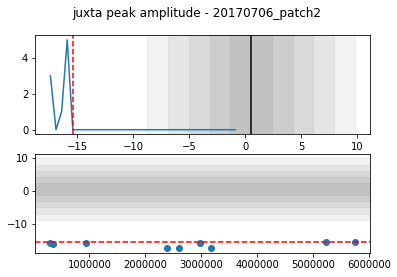

In [7]:
plot_juxta_amplitude('20170706_patch2')

## Figure for 20170629_patch2

Here the peak amplitude distribution crosses the detection threhold.
Missed events are obvious in the middle part of recording.

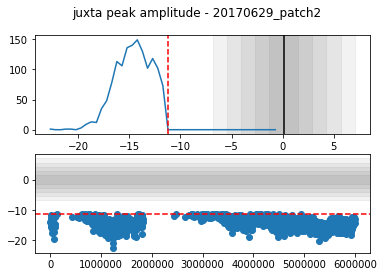

In [8]:
plot_juxta_amplitude('20170629_patch2')

## Figure for 20170622_patch2

Here the peak amplitude distribution crosses the detection threhold and too few events got detected.

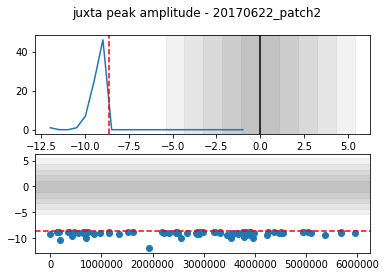

In [9]:
plot_juxta_amplitude('20170622_patch2')

## Figure for 20170726_patch1

Here again the peak amplitude distribution crosses the detection threhold.
Some spikes are clearly missed at the begnning.

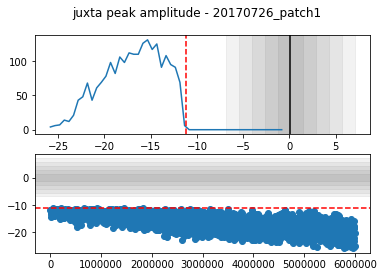

In [11]:
plot_juxta_amplitude('20170726_patch1')

## Figure for 20170706_patch1

Obvious missing spikes.

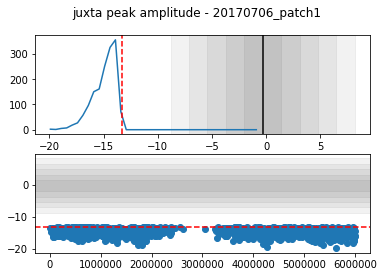

In [12]:
plot_juxta_amplitude('20170706_patch1')

## Figure for 20170706_patch3

Obvious missing spikes.

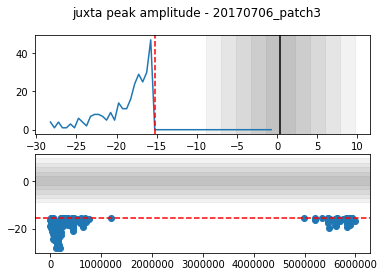

In [13]:
plot_juxta_amplitude('20170706_patch3')

## Figure for 20170627_patch1

Obvious missing spikes

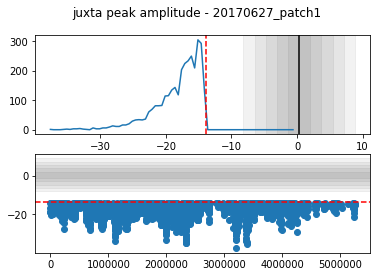

In [14]:
plot_juxta_amplitude('20170627_patch1')

## Figure for 20170630_patch1

Suspicion of missing spikes at the beggining and at the end of recording.

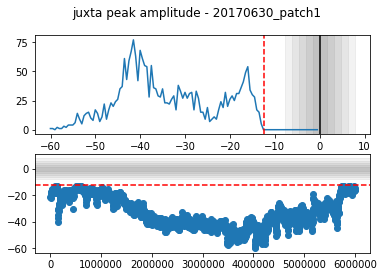

In [15]:
plot_juxta_amplitude('20170630_patch1')

## Figure for 20170629_patch3

Obvious missing spikes.

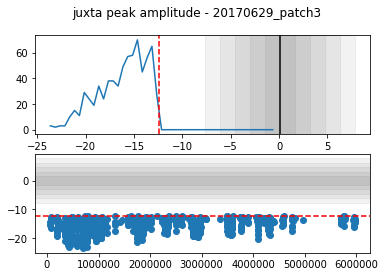

In [16]:
plot_juxta_amplitude('20170629_patch3')

## Figure for 20170623_patch1 : NO

Here the amplitude distribution right tail is too close to the detection threhold and there is a suspicion of missed spikes. 

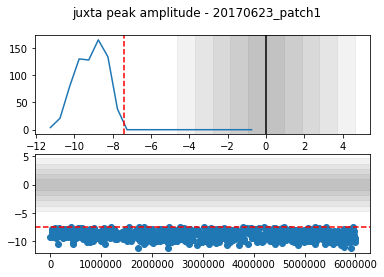

In [18]:
plot_juxta_amplitude('20170623_patch1')

# List of clean ground truth

## Figure for 20170713_patch1 : OK, but boundary

We see here two clear peaks in the distribution suggesting that there could be an electrode movement.

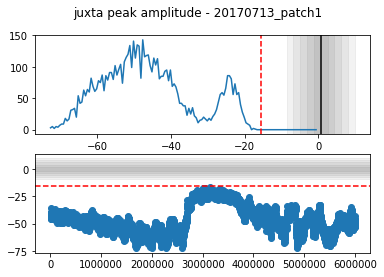

In [19]:
plot_juxta_amplitude('20170713_patch1')

## Figure for 20160415_patch2 : OK

A ground truth unit we can trust!!

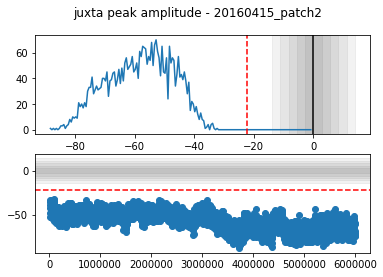

In [20]:
plot_juxta_amplitude('20160415_patch2')

## Figure for 20170803_patch1 : OK

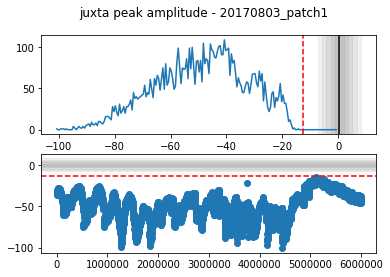

In [21]:
plot_juxta_amplitude('20170803_patch1')

## Figure for 20160426_patch3 : OK

A ground truth we can trust!!

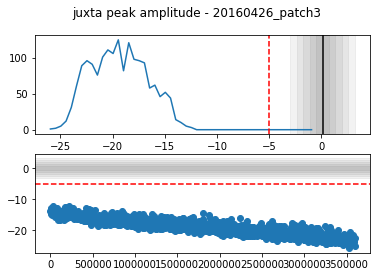

In [23]:
plot_juxta_amplitude('20160426_patch3')

## Figure for 20170725_patch1 : OK but bundary

A ground truth we can trust, but there is a suspicious change in amplitude in the middle of recording.

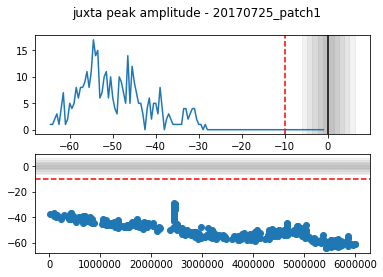

In [25]:
plot_juxta_amplitude('20170725_patch1')

## Figure for 20170621_patch1 : OK

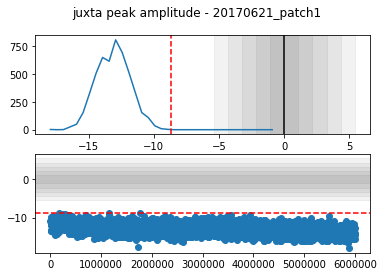

In [26]:
plot_juxta_amplitude('20170621_patch1')

## Figure for 20160426_patch2 : OK

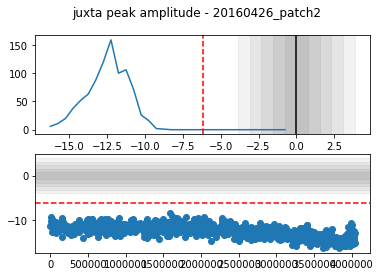

In [27]:
plot_juxta_amplitude('20160426_patch2')

## Figure for 20170728_patch2 : OK

Ok but some movement at the end...

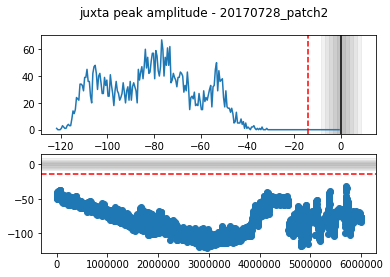

In [28]:
plot_juxta_amplitude('20170728_patch2')

# Conclusion

  * 11 out of 19 files have been removed for further ground-truth analysis.
  * 8 out of 19 files are kept for ground-truth analysis.

For paired recording ground truth, the ground truth itself has to be carefully verified.

The original ground spike index provided on 19 files by the authors are not trustable for a fair spike sorting comparison.